In [1]:
import torch
import sys
from torchviz import make_dot
import numpy as np

In [2]:
sys.path.append('../src')
sys.path.append('../src/ml_variants/unet/pipelines/training/')

In [3]:
from ml_variants.unet.pipelines.training.steps.trainers import Sat2Rad

In [4]:
model = Sat2Rad()

cpu


In [5]:
input = torch.ones((2, 16, 16))

In [6]:
input

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1.,

In [7]:
# yhat = model(np.zeros((1, 1)))

In [8]:
import os
from util.parse_time import *
import matplotlib.pyplot as plt

In [9]:
model = Sat2Rad.load_from_checkpoint("../src/ml_variants/unet/pipelines/training/lightning_logs/version_30/checkpoints/epoch=39-step=105720.ckpt")

cpu


In [10]:
def loadFile(file: str):
    arr = np.load(file)
    return addTimeDim(arr, file)


def addTimeDim(array: np.ndarray, time: str):
    now = parseTime(time).hour / 24
    times = np.array([now]).repeat(256 * 256).reshape((1, 256, 256))
    return np.concatenate((array, times), axis=0)

In [145]:
start = 308

In [146]:
originals = order_based_on_file_timestamp(os.listdir('../data/preprocessed/satellite/'))[start:start+8]

In [147]:
radars = order_based_on_file_timestamp(os.listdir('../data/preprocessed/radar'))

In [148]:
timesRadar = [parseTime(s) for s in radars]

In [149]:
originals[0]

'MSG4-SEVI-MSG15-0100-NA-20230305055742.617000000Z-NA.npy'

In [150]:
start, end = get_next_sequence(8, originals[-1], radars)

In [151]:
radarimg = [np.load(f"../data/preprocessed/radar-binned/{x}") for x in radars[start:end]]

In [152]:
times = [parseTime(s) for s in originals]
timesRadar = [parseTime(s) for s in radars[start:end]]

In [153]:
x = [loadFile(f"../data/preprocessed/satellite/{x}") for x in originals]

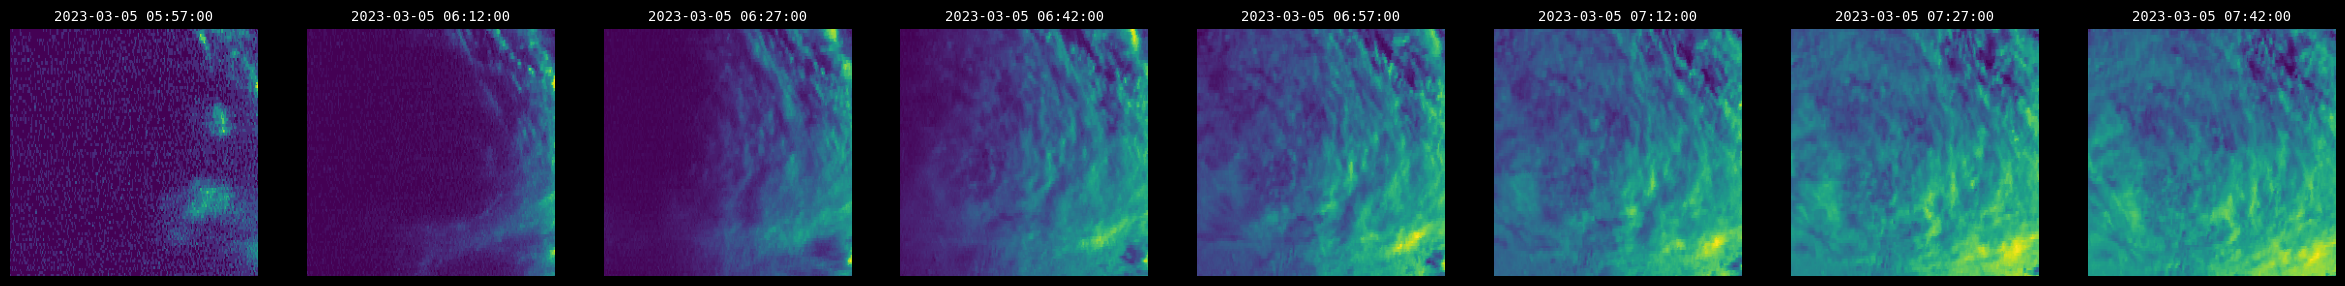

In [154]:
f, a = plt.subplots(1, 8, figsize=(30, 10))
for i, dd in enumerate(x):
    a[i].imshow(dd[0])
    a[i].grid(True)
    a[i].axis('off')
    a[i].set_title(f"{times[i]}", color='white', font="monospace")

f.set_facecolor("black")

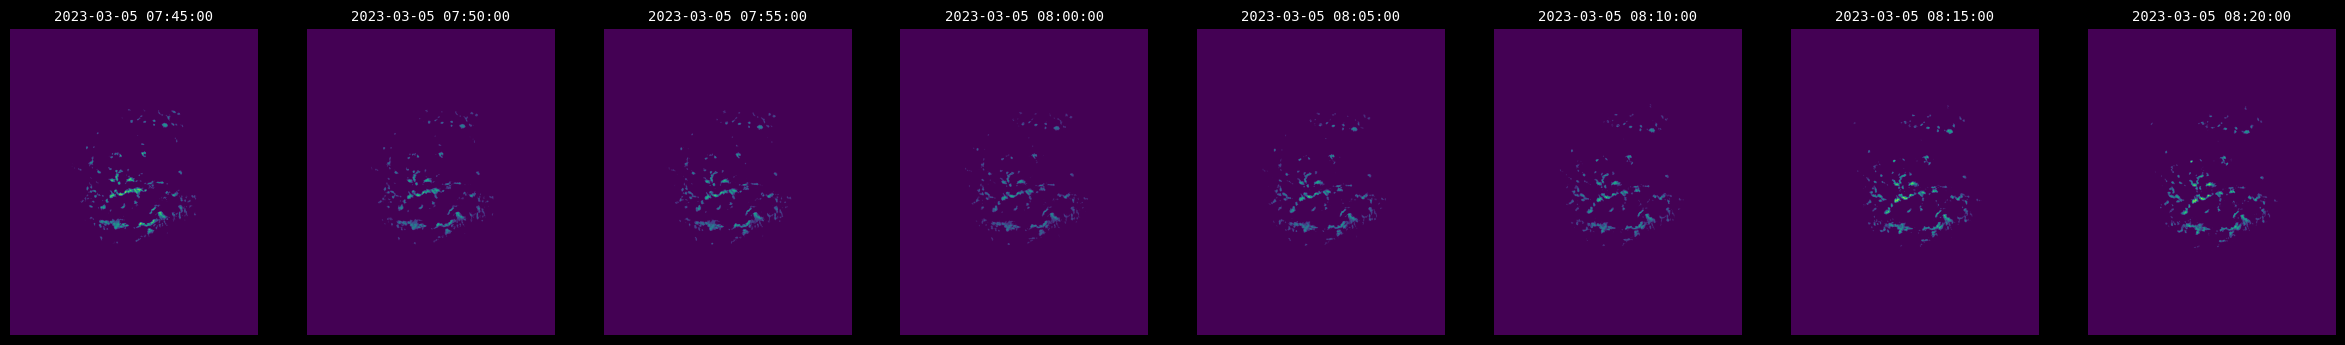

In [155]:
f, a = plt.subplots(1, 8, figsize=(30, 10))

for i, rest in enumerate(radarimg):
    a[i].imshow(rest)
    a[i].grid(True)
    a[i].axis('off')
    a[i].set_title(f"{timesRadar[i]}", color='white', font="monospace")

f.set_facecolor("black")

In [156]:
x = torch.from_numpy(np.array(x)).float().cuda()

In [157]:
test = (x, torch.zeros(1).cuda())

In [158]:
model.cuda()

Sat2Rad(
  (unet): UNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (groupnorm): GroupNorm(1, 12, eps=1e-05, affine=True)
            (conv): Conv3d(12, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (SingleConv2): SingleConv(
            (groupnorm): GroupNorm(1, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
        )
      )
      (1): Encoder(
        (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (groupnorm): GroupNorm(1, 64, eps=1e-05, affine=True)
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), b

In [161]:
model.eval()

with torch.no_grad:
    y_hat = model(test)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_38906/3632572134.py:3 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_38906/3632572134.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: __enter__

In [162]:
whattat = model(test)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_38906/2548131265.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_38906/2548131265.py'                        │
│                                                                                                  │
│ /home/mark/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/mark/Projects/bsc_thesis/sandbox/../src/ml_variants/unet/pipelines/training/steps/trainers │
│ .py:124 in forward                                                                               │
│                                                                                                  │
│   121 │   def forward(self, batch: tuple[torch.Tensor, torch.Tensor]):                           │
│   122 │   │   x, y = batch                                                                       │
│   123 │   │   x = x.reshape(-1, 12, 8, 256, 256)                                                 │
│ ❱ 124 │   │   x = self.unet(x)                                                                   │
│   125 │   │   x = x.reshape(-1, 8, 8, 256, 256)                                                  │
│   126 │   │   x = torch.squeeze(self.classifer(x), 1)                                            │
│   127                                                                                            │
│                                                                                                  │
│ /home/mark/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/mark/Projects/bsc_thesis/sandbox/../src/layers/Unet3d.py:127 in forward                    │
│                                                            

In [123]:
next(model.parameters()).is_cuda # returns a boolean

True

In [124]:
y_hat.shape

torch.Size([1, 8, 256, 256])

In [125]:
tttt = torch.softmax(y_hat, dim=1)

In [126]:
tttt.shape

torch.Size([1, 8, 256, 256])

In [127]:
torch.sum(tttt[0,:,0,0])

tensor(1., device='cuda:0')

In [128]:
pp = torch.argmax(tttt, axis=1)

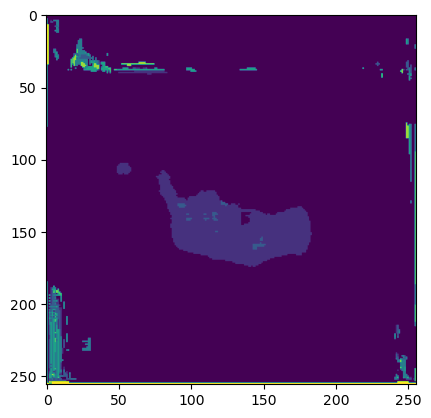

In [129]:
plt.imshow(pp.cpu().detach()[0])

In [130]:
import torchmetrics

In [131]:
cm = torchmetrics.ConfusionMatrix('multiclass', num_classes=8).to('cuda')

In [132]:
from torchvision.transforms.functional import resize, InterpolationMode

In [133]:
test = torch.from_numpy(radarimg[1])

In [134]:
test.shape

torch.Size([1660, 1340])

In [135]:
test = test.view(1, 1660, 1340)

In [136]:
y = resize(test, [256, 256], interpolation=InterpolationMode.NEAREST)

In [137]:
y = y.to('cuda')

In [138]:
y.device

device(type='cuda', index=0)

In [139]:
pp.device

device(type='cuda', index=0)

In [140]:
res = cm(pp, y)

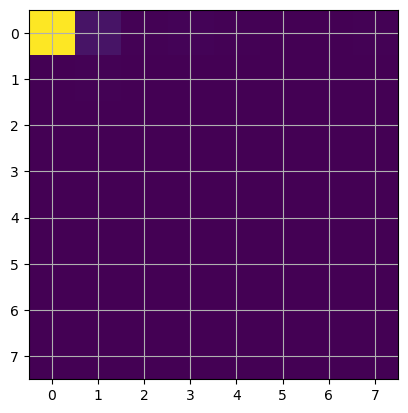

In [141]:
plt.imshow(res.cpu().detach().numpy())
plt.grid()

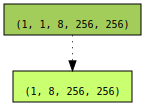

In [142]:
make_dot(y_hat)

In [164]:
from torch import nn

In [187]:
encode = nn.Sequential(
    nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=34, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=34, out_channels=64, kernel_size=3, stride=2),
)

In [188]:
image = torch.randn(1, 12, 256, 256)

In [189]:
out = encode(image)

In [190]:
out.shape

torch.Size([1, 64, 62, 62])